<a href="https://colab.research.google.com/github/aymanish/pbrx/blob/main/Main_PBRX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [309]:
!pip install deap
!pip install seaborn
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [310]:
import random
import numpy
import matplotlib.pyplot as plt
import scipy.io
%matplotlib inline
from deap import algorithms, base, creator, tools

In [431]:
#Define Problem:

#NUM_TASKS = 10

#TASK_POS = [[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]]
#TASK_POS = [[1,1], [1, 2], [3,3], [6,6], [6,7]]
NUM_ROBOTS = 4

ROBOT_POS = [[1,0], [4,0], [7,0], [10, 0]] #[6,4]
#ROBOT_POS = [[1,0], [3,0], [5,0], [7,0], [10, 0]] #[6,4]


#ROBOT_BATTERY_CAPS = [10, 8, 6]
#TASK_PRIORITIES = [20, 30 , 40]
#TASKS_PER_ROBOT = 3

In [432]:
#dictionaries storing task and robot locations for easier access and mapping:
#this way i dont need to implement classes for tasks and robots:
#do similar for robot capacities
# how DO I AUTOMATE THIS:

#make list of task locations and use num tasks to make dict
#that adapts to nums
#add task scores, consumption, time taken as well
#HOW DO I UPDATE ROBOT BATTERY FOR EACH GENERATION
#[1,1], [1,2], [0,1], [3,2], [3,4], [3, 3], [7,6], [8,6], [7,8], [8, 8]
"""
task_dict = {
  0: [1, 1],
  1: [1, 2],
  2: [0, 1],
  3: [3, 2],
  4: [3, 4],
  5: [3, 3],
  6: [7, 6],
  7: [8, 6],
  8: [7, 8],
  9: [8, 8],
}
"""

"""
#time adjusted task_dict: --> keep task times all the same to see how the behaviour changes in terms of minimizing time without any bias
task_dict = {
    0: [[1, 1], 5],
    1: [[1, 2], 5],
    2: [[0, 1], 5],
    3: [[3, 2], 5],
    4: [[3, 4], 5],
    5: [[3, 3], 5],
    6: [[7, 6], 5],
    7: [[8, 6], 5],
    8: [[7, 8], 5],
    9: [[8, 8], 5],
}

#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [3, 0],
  3: [6, 4],
  4: [5, 6]
}
"""
task_dict = {
	0: [[1, 1], 5],
	1: [[1, 2], 5],
	2: [[0, 1], 5],
	3: [[3, 2], 5],
	4: [[3, 4], 5],
	5: [[3, 3], 5],
	6: [[7, 6], 5],
	7: [[8, 6], 5],
	8: [[7, 8], 5],
	9: [[8, 8], 5],
  10: [[0, 3], 5],
  11: [[0, 4], 5],
  12: [[1, 6], 5],
  13: [[2, 6], 5],
  14: [[4, 6], 5],
  15: [[5, 3], 5],
  16: [[7, 4], 5],
  17: [[5, 7], 5],
  18: [[8, 2], 5],
  19: [[10, 4], 5],
  20: [[11, 6], 5],

}

"""
  21: [[9, 5], 5],
  22: [[0, 9], 5],
  23: [[7, 3], 5],
  24: [[11, 1], 5],
  25: [[8, 12], 5],
  26: [[12, 10], 5],
  27: [[12, 2], 5],
  28: [[12, 6], 5],
  29: [[11, 4], 5],
  30: [[8, 11], 5]
"""
#add robot capacities as well - minimizing distance is the same as minimizing
robot_dict = {
  1: [1, 0],
  2: [4, 0],
  3: [7, 0],
  4: [10, 0]
}

coordinates_list = [info[0] for info in task_dict.values()]
print(coordinates_list)
TASK_POS = coordinates_list
NUM_TASKS = len(TASK_POS)

print(NUM_TASKS)
#print(task_dict)
#print(task_dict[1]) #get [x, y] for task 1: index [0] or [1] to get x or y respectively

[[1, 1], [1, 2], [0, 1], [3, 2], [3, 4], [3, 3], [7, 6], [8, 6], [7, 8], [8, 8], [0, 3], [0, 4], [1, 6], [2, 6], [4, 6], [5, 3], [7, 4], [5, 7], [8, 2], [10, 4], [11, 6]]
21


In [433]:
tasks = random.sample(range(0, NUM_TASKS), NUM_TASKS)

print(tasks)
print(TASK_POS[1-1])
print(ROBOT_POS[3-1])

[0, 5, 7, 2, 4, 17, 1, 19, 8, 13, 11, 12, 6, 20, 9, 16, 15, 10, 14, 18, 3]
[1, 1]
[7, 0]


In [434]:
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#creator.create("Individual", list, fitness=creator.FitnessMin) #[t1, t2, t3, t4, tm | ]

#toolbox = base.Toolbox()

#toolbox.register("attr_bool", random.randint, 0, 1)
#toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=18)
#toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [435]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def create_chromosome (n, m): #n robots, m tasks
  chromosome = []

  #tasks = random.sample(range(1, m + 1), m) #create random permutation on m tasks
  tasks = random.sample(range(0, m), m) #create random permutation on m tasks
  robots = robots = [random.randint(1, n) for x in range(m)] #create random permutation of m assignments of n robots

  chromosome = tasks + robots
  return chromosome

#print(chromosome[:NUM_TASKS]) # tasks
#print(chromosome[NUM_TASKS:]) # robot assignments
#make dict of robots and tasks associated with their (x,y) coordinates

toolbox = base.Toolbox()
#toolbox.register("tasks", random.sample, range(NUM_TASKS), NUM_TASKS)
toolbox.register("chromosome", create_chromosome, NUM_ROBOTS, NUM_TASKS)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.chromosome)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [436]:
import math

"""
#new better base function code:
def get_coordinates(task_or_robot, dict): #coordinates = [[x,y]] #use on robot and tasks
  return dict[task_or_robot]

def get_all_coordinates(tasks_or_robots, dict):
  all_coordinates = []
  for task_or_robot in tasks_or_robots:
    all_coordinates.append(get_coordinates(task_or_robot, dict)) #tasks and robots start at 1 so need to offset with -1 back to 0
  return all_coordinates #list of coordinates ordered with task order

def get_distances(individual): #def get_distances(task_coords, robot_coords, ind):
  ind_tasks = individual[:NUM_TASKS] # [t1, t2, t3, t4, t5]
  ind_robots = individual[NUM_TASKS:] # [r1, r2, r3, r4, r5]

  ind_task_pos = get_all_coordinates(ind_tasks, task_dict) #change these to map onto tasks and robots
  ind_robot_pos = get_all_coordinates(ind_robots, robot_dict) #change these to map onto tasks and robots

  #print(ind_task_pos)
  #print(ind_robot_pos)

  # ind_task_pos =  [ [xt1,yt1], [xt2,yt2], [xt3,yt3], [xt4,yt4], [xt5,yt5] ]
  # int_robot_pos = [ [xr1,yr1], [xr2,yr2], [xr3,yr3], [xr4,yr4], [xr5,yr5] ]

  distances = list(map(math.dist, ind_task_pos, ind_robot_pos))
  return distances

def sum_distances(distances):
  return sum(distances)

def evalSchedule(individual):
  sum = sum_distances(get_distances(individual))
  return (sum,)
"""

"""
#new better fitness function f2 - WORKS WITH OLD TASK_DICT
import numpy as np

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Modified fitness function for distance that takes into account the changing robot position after each task
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    return total_distance



#new better fitness function f2
import numpy as np

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Modified fitness function for distance that takes into account the changing robot position after each task
# and the new structure of task_dict which now includes task duration
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    distances_per_robot = {robot: 0 for robot in set(robots)}  #
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions
    for task, robot in zip(tasks, robots):
        # Change here: Extract just the task location from the new task_dict structure
        task_location = task_dict[task][0]  # Now task_dict[task] is a list, task_location is the first element
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        distances_per_robot[robot] += distance_to_task  # Sum distance for each robot #
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location
    average_distance = total_distance / len(tasks)
    return total_distance, average_distance, distances_per_robot

#original time function:
# Updated fitness function considering task_dict now uses lists
def total_time_fitness3(tasks, robots, task_dict, robot_dict):
    robot_positions = robot_dict.copy()  # Maintain original starting positions
    robot_end_times = {robot: 0 for robot in robot_dict}  # Track when each robot is free

    for task, robot in zip(tasks, robots):
        task_location, task_duration = task_dict[task]  # Unpacking directly from the list
        robot_location = robot_positions[robot]

        # Calculate travel time to the task
        travel_time = calculate_distance3(robot_location, task_location) / speed

        # Start time for this task
        start_time = max(robot_end_times[robot], robot_end_times[robot] + travel_time)

        # Update robot's end time after this task
        robot_end_times[robot] = start_time + task_duration

        # Update robot position
        robot_positions[robot] = task_location

    # The fitness is the maximum of end times across all robots
    return max(robot_end_times.values())
    #return (max(robot_end_times.values()),)
    #return (sum(robot_end_times.values()),) #acts the same as total distance so not really beneficial
"""
#improved fitness function that takes going back home into account
import numpy as np
# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
# Modified fitness function for distance that takes into account the changing robot position after each task
# and the new structure of task_dict which now includes task duration
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    #distances_per_robot = {robot: 0 for robot in set(robots)}
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        # Change here: Extract just the task location from the new task_dict structure
        task_location = task_dict[task][0]  # Now task_dict[task] is a list, task_location is the first element
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        #distances_per_robot[robot] += distance_to_task  # Sum distance for each robot
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    # Calculate distance for each robot to return to its initial position
    for robot, initial_position in robot_dict.items():
        # Get the final position of the robot after completing all tasks
        final_position = robot_positions[robot]
        # Calculate the distance from the final position back to the initial position
        distance_to_initial_position = calculate_distance(final_position, initial_position)
        # Add this distance to the total distance and the distance for this robot
        total_distance += distance_to_initial_position
        #distances_per_robot[robot] += distance_to_initial_position

    average_distance = total_distance / len(tasks)
    return total_distance, average_distance#, distances_per_robot


#def evalSchedule(individual):
#  tasks = individual[:NUM_TASKS]
#  robots = individual[NUM_TASKS:]
#  sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
#  return (sum,) #try dividing by tasks



# Function to calculate Euclidean distance between two points
def calculate_distance3(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Assume constant speed for simplicity
speed = 1.0  # units per time unit

def total_time_fitness_with_return(tasks, robots, task_dict, robot_dict):
    robot_positions = robot_dict.copy()  # Maintain original starting positions
    robot_end_times = {robot: 0 for robot in robot_dict}  # Track when each robot is free

    for task, robot in zip(tasks, robots):
        task_location, task_duration = task_dict[task]  # Unpacking directly from the list
        robot_location = robot_positions[robot]

        # Calculate travel time to the task
        travel_time = calculate_distance3(robot_location, task_location) / speed

        # Start time for this task
        start_time = max(robot_end_times[robot], robot_end_times[robot] + travel_time)

        # Update robot's end time after this task
        robot_end_times[robot] = start_time + task_duration

        # Update robot position
        robot_positions[robot] = task_location

    # Calculate travel time to return to initial position for each robot
    for robot, end_time in robot_end_times.items():
        initial_position = robot_dict[robot]  # Initial position of the robot
        return_travel_time = calculate_distance3(robot_positions[robot], initial_position) / speed
        robot_end_times[robot] += return_travel_time  # Add return travel time to end time

    # The fitness is the maximum of end times across all robots
    return max(robot_end_times.values())


def evalSchedule(individual):
  tasks = individual[:NUM_TASKS]
  robots = individual[NUM_TASKS:]
  #sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
  max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
  total_distance, average_distance= updated_distance_fitness(tasks, robots, task_dict, robot_dict)
  #print(distances_per_robot[1])
  #std_dev_distances = np.std(list(distances_per_robot.values()))

  #fitness = 0.0*sum1# + 1.0*sum2
  #weight = 1 / NUM_ROBOTS
  #fitness = 0

  #distance_per_robot = total_distance / len(set(robots))

  #for r in range(len(distances_per_robot)):
  #  fitness += weight*distances_per_robot[r+1]
  #fitness = weight*distances_per_robot[1] + weight*distances_per_robot[2] + weight*distances_per_robot[3] + weight*distances_per_robot[4]
  #fitness1 = std_dev_distances
  #print( total_distance, max_time_taken)
  return (max_time_taken,)
  #MAIN #return (0.5*average_distance + 0.5*max_time_taken,) #try dividing by tasks --> robots makes more sense? #also include tasks per robot variance
  #return (0.5*max_time_taken + 0.5*total_distance,)

In [437]:
tasks = [0,2,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
robots = [1,1,1,2,2,2,3,3,3,3,1,2,3,1,2,3,4,4,4,3,2,2,3,4,4,3,2,2,1,1,2]
print(len(robots))
#tasks = [0,1,2,3,4]
#robots = [1,1,2,3,3]


#print(get_all_coordinates(tasks, task_dict))
#print(get_all_coordinates(robots, robot_dict)) #this needs to be updated for distances
ind = tasks + robots#[0,1,2,3,4,1,1,2,3,3]
#print(evalSchedule(ind))

31


In [438]:
"""
import numpy as np

# Function to calculate Euclidean distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Modified fitness function for distance that takes into account the changing robot position after each task
def updated_distance_fitness(tasks, robots, task_dict, robot_dict):
    total_distance = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        total_distance += distance_to_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    return total_distance


# Fitness function for fuel consumption that accounts for changing robot position
def updated_fuel_consumption_fitness(tasks, robots, task_dict, robot_dict, alpha, delta):
    total_fuel_consumption = 0
    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions

    for task, robot in zip(tasks, robots):
        task_location = task_dict[task]
        robot_location = robot_positions[robot]
        distance_to_task = calculate_distance(robot_location, task_location)
        fuel_consumption_for_task = alpha * (distance_to_task / 1.0)  # Assuming velocity v_ij = 1 for all robots
        total_fuel_consumption += fuel_consumption_for_task
        # Update the robot's position to the location of the task it just completed
        robot_positions[robot] = task_location

    total_fuel_consumption *= delta
    return total_fuel_consumption


# Calculate the updated fitness for distance and fuel consumption
updated_distance_fitness_score = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
#updated_fuel_consumption_fitness_score = updated_fuel_consumption_fitness(tasks, robots, task_dict, robot_dict, alpha, delta)

"""




"\nimport numpy as np\n\n# Function to calculate Euclidean distance between two points\ndef calculate_distance(p1, p2):\n    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)\n\n# Modified fitness function for distance that takes into account the changing robot position after each task\ndef updated_distance_fitness(tasks, robots, task_dict, robot_dict):\n    total_distance = 0\n    robot_positions = robot_dict.copy()  # Copy to maintain the original starting positions\n\n    for task, robot in zip(tasks, robots):\n        task_location = task_dict[task]\n        robot_location = robot_positions[robot]\n        distance_to_task = calculate_distance(robot_location, task_location)\n        total_distance += distance_to_task\n        # Update the robot's position to the location of the task it just completed\n        robot_positions[robot] = task_location\n\n    return total_distance\n\n\n# Fitness function for fuel consumption that accounts for changing robot position\ndef updated_f

In [439]:
toolbox.register("evaluate", evalSchedule)
toolbox.register("select", tools.selTournament,tournsize=3) #10 did well - SO DID 20
 #3


from deap import tools

def custom_crossover_single_child(ind1, ind2):
    # Clone the input individuals to avoid modifying the originals
    copy1, copy2 = toolbox.clone(ind1), toolbox.clone(ind2)
    #print("copy1:")
    #print(copy1)
    #print("copy2:")
    #print(copy2)

    # Extract the tasks halves
    tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

    # Apply PMX only to the tasks halves and take one of the resulting halves for the child
    #tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2) # cxUniformPartialyMatched
    tasks_half_child, _ = tools.cxUniformPartialyMatched(tasks_half1, tasks_half2, 0.01)
    # For the robot assignments half, choose one parent's half to combine with the tasks half of the child
    # This example chooses the robot assignments half from the first parent
    child = tasks_half_child + copy1[NUM_TASKS:]

    # Clear the fitness value of the child since it's a new individual
    #del child.fitness.values

    #print(child)
    return child,


# Register the custom crossover function in the toolbox
toolbox.register("mate", custom_crossover_single_child)

MUTATION_P = 0.001#.001 #0.1

toolbox.register("mutate_robots", tools.mutUniformInt, low=1, up=NUM_ROBOTS, indpb=MUTATION_P) #0.1
toolbox.register("mutate_tasks", tools.mutShuffleIndexes, indpb=MUTATION_P) #0.1 -> what ahppens if i set this to zero - can be used for ablation studies

def mutate(individual): #THIS NEEDS TO DIRECTLY CHANGE THE IND AND NOT THE COPY - implemented (further checking needed)
    # Make a copy of the individual to avoid direct modifications
    #ind_copy = toolbox.clone(individual) #to revert just change individual with ind_copy

    # Perform mutation on the tasks half
    tasks_half = individual[:NUM_TASKS]
    mutated_tasks_half, = toolbox.mutate_tasks(tasks_half)
    individual[:NUM_TASKS] = mutated_tasks_half

    # Perform mutation on the robot assignments half
    robot_assignments_half = individual[NUM_TASKS:]
    mutated_robot_assignments_half, = toolbox.mutate_robots(robot_assignments_half)
    individual[NUM_TASKS:] = mutated_robot_assignments_half

    # Clear the fitness values of the mutated individual
    #del ind_copy.fitness.values
    #print individual

    return individual,

# Ensure the 'mutate' function is registered correctly in the toolbox
toolbox.register("mutate", mutate)

In [440]:
#pop1 = toolbox.population(n=5)
#for ind in pop1:
#  #each ind is a list
#  ind_tasks = ind[:NUM_TASKS]
#  ind_robots = ind[NUM_TASKS:]
#  print(ind, len(ind))
#  print(ind_tasks, len(ind_tasks), '\n', ind_robots, len(ind_robots), '\n')
#  print(evalSchedule(ind))

pop2 = toolbox.population(n=10)

# Evaluate the initial population
fitnesses = [toolbox.evaluate(ind) for ind in pop2]
for ind, fit in zip(pop2, fitnesses):
    ind.fitness.values = fit
    print(ind)
    print(ind[:NUM_TASKS])
    print(ind[NUM_TASKS:])
    print(ind.fitness.values)

# Select the next generation individuals
offspring = toolbox.select(pop2, len(pop2))
print('offspring')
print(offspring)

print("CHECK MUTATOR")
copy1, copy2 = toolbox.clone(offspring[0]), toolbox.clone(offspring[2])

print("UNMUTATED:")
print(copy1)

#toolbox.mutate(copy1)
print("MUTATED:")
print(copy1)
# Apply crossover and mutation on the offspring
#for child1, child2 in zip(offspring[::2], offspring[1::2]): #seperate betwee odds and evens
    #if random.random() < CXPB:
    #toolbox.mate(child1, child2)
    #del child1.fitness.values
    #del child2.fitness.values

    # Clone the selected individuals
    #offspring = list(map(toolbox.clone, offspring))
#toolbox.mate(pop2[0], pop2[2])
#del pop2[0].fitness.values
#del pop2[2].fitness.values

# Clone the input individuals to avoid modifying the originals
copy1, copy2 = toolbox.clone(offspring[0]), toolbox.clone(offspring[2])
print("copy1:")
print(copy1)
print("copy2:")
print(copy2)

# Extract the tasks halves
tasks_half1, tasks_half2 = copy1[:NUM_TASKS], copy2[:NUM_TASKS]

print("task1, task2: ")
print(tasks_half1, tasks_half2)

#tools.cxPartialyMatched(tasks_half1, tasks_half2)

size = min(len(tasks_half1), len(tasks_half2))
print(size)
p1, p2 = [0] * size, [0] * size
print(p1, p2)

# Initialize the position of each indices in the individuals
"""
for i in range(size):
    print(i)
    p1[tasks_half1[i]] = i

    print("p1")
    print(p1[tasks_half1[i]])

    p2[tasks_half2[i]] = i

    print("p2")
    print(p2[tasks_half2[i]])
"""



# Apply PMX only to the tasks halves and take one of the resulting halves for the child
#tasks_half_child, _ = tools.cxPartialyMatched(tasks_half1, tasks_half2)

# For the robot assignments half, choose one parent's half to combine with the tasks half of the child
# This example chooses the robot assignments half from the first parent#
#child = tasks_half_child + copy1[NUM_TASKS:]

ind1 = [0, 2, 3, 1, 4]
ind2 = [0, 1, 2, 3, 4]

#ind1 = [0, 1, 2, 3, 4, 5, 6, 7]
#ind2 = [2, 6, 4, 0, 5, 7, 1, 3]

t1, t2 = [0, 1, 3, 5, 2, 4] , [0, 4, 3, 5, 1, 2]

print("inds:")
print(ind1, ind2)

child1, child2 = tools.cxPartialyMatched(ind1, ind2)
print("children:")
print(child1, child2)

print("T")
print(t1, t2)
t1c, t2c = tools.cxPartialyMatched(t1, t2)
print("T children:")
print(t1c, t2c)

print("tasks")
print(tasks_half1, tasks_half2)
child1, child2 = tools.cxPartialyMatched(tasks_half1, tasks_half2)
print(child1, child2)


[9, 16, 18, 19, 6, 17, 13, 15, 10, 5, 20, 3, 1, 7, 0, 8, 14, 12, 11, 4, 2, 1, 3, 4, 2, 3, 2, 3, 2, 3, 2, 2, 2, 1, 1, 3, 1, 4, 3, 3, 2, 1]
[9, 16, 18, 19, 6, 17, 13, 15, 10, 5, 20, 3, 1, 7, 0, 8, 14, 12, 11, 4, 2]
[1, 3, 4, 2, 3, 2, 3, 2, 3, 2, 2, 2, 1, 1, 3, 1, 4, 3, 3, 2, 1]
(77.65343572670763,)
[3, 11, 0, 13, 4, 15, 12, 8, 14, 16, 9, 2, 6, 17, 20, 7, 19, 18, 10, 5, 1, 3, 1, 2, 2, 2, 1, 4, 2, 1, 3, 3, 1, 1, 2, 1, 1, 3, 4, 3, 3, 4]
[3, 11, 0, 13, 4, 15, 12, 8, 14, 16, 9, 2, 6, 17, 20, 7, 19, 18, 10, 5, 1]
[3, 1, 2, 2, 2, 1, 4, 2, 1, 3, 3, 1, 1, 2, 1, 1, 3, 4, 3, 3, 4]
(78.60939676114718,)
[5, 6, 2, 17, 10, 20, 4, 0, 16, 9, 13, 8, 11, 14, 19, 18, 12, 7, 1, 15, 3, 2, 4, 4, 1, 3, 3, 2, 2, 2, 1, 3, 1, 3, 4, 2, 3, 4, 1, 1, 1, 3]
[5, 6, 2, 17, 10, 20, 4, 0, 16, 9, 13, 8, 11, 14, 19, 18, 12, 7, 1, 15, 3]
[2, 4, 4, 1, 3, 3, 2, 2, 2, 1, 3, 1, 3, 4, 2, 3, 4, 1, 1, 1, 3]
(78.56430168783638,)
[10, 11, 15, 14, 18, 2, 17, 3, 12, 7, 20, 8, 5, 13, 1, 4, 6, 0, 9, 16, 19, 2, 1, 4, 4, 1, 4, 4, 1, 2, 4, 2

In [441]:
logbook = tools.Logbook()
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [442]:
def genetic_diversity(population):
    diversity = {}
    # Assuming all individuals in the population have the same length
    for i in range(len(population[0])):
        gene_values = [individual[i] for individual in population]
        diversity[i] = numpy.var(gene_values)
    return diversity

gen	evals	avg   	std    	min    	max   
0  	300  	76.214	7.66827	64.2362	112.39
1  	300  	70.4222	3.99218	64.2362	83.7624
2  	300  	67.27  	2.62317	64.2362	80.0073
3  	300  	65.4594	1.89531	60.6393	85.8579
4  	300  	64.5226	0.962049	60.6393	71.5471
5  	300  	64.2492	0.992715	60.6393	75.8793
6  	300  	64.1604	1.674   	60.6393	79.8951
7  	300  	63.6312	1.48389 	60.6393	75.6144
8  	300  	62.8065	1.72956 	60.6393	75.5393
9  	300  	61.5661	1.31591 	59.6867	70.9044
10 	300  	60.8019	1.05287 	59.6867	72.2991
11 	300  	60.7362	1.00471 	57.8579	71.6973
12 	300  	60.7089	1.09486 	57.8579	71.2388
13 	300  	60.5588	0.804709	57.8579	69.9987
14 	300  	60.3983	1.07811 	57.8579	71.6973
15 	300  	59.9359	1.84927 	57.8579	79.3769
16 	300  	59.0525	1.74284 	57.6469	78.0866
17 	300  	58.2654	1.43256 	55.4896	69.7543
18 	300  	57.9965	1.34229 	55.4896	69.386 
19 	300  	57.787 	1.63166 	55.4896	79.3769
20 	300  	57.4073	1.63383 	55.4896	69.9987
21 	300  	56.7848	2.06924 	55.4896	72.8644
22 	300  	56.0584	1.

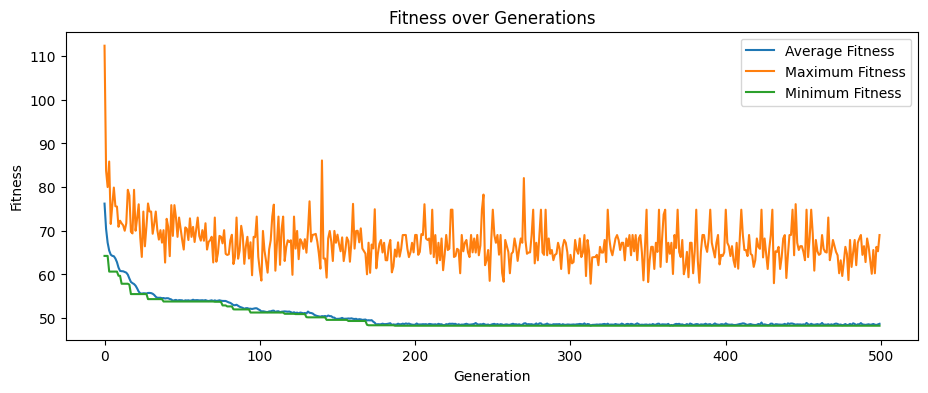

In [443]:
import matplotlib.pyplot as plt
import numpy

# Assuming you have these already defined
# toolbox, create_chromosome, etc.

# Initialize population
pop = toolbox.population(n=300) #300

# Evaluate the initial population
fitnesses = [toolbox.evaluate(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Prepare the statistics object
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

# Number of generations
NGEN = 500#1000#50#100 -> IMPROVEMENT IS SLOW AFTER 50 GENS
CXPB = 1.0#0.1 #0.1 -> CXPB OF 0.01 and MUTPB OF 0.1 Produced interesting results
MUTPB = 1.0#0.1 #0.1#0.2 - 0.5 did wose on avg fitness but still produced best result - most solutions arent good - but didnt check diversity
#0.001 - max fitness decreases
diversity_over_time = []

for gen in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Update the statistics with the new population
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)

    print(logbook.stream)

    #print best individual per generation
    #indv = tools.selBest(pop, 1)[0]
    #print(indv)
    diversity_over_time.append(genetic_diversity(pop))

# Extract statistics
gen = logbook.select("gen")
avg_fit = logbook.select("avg")
max_fit = logbook.select("max")
min_fit = logbook.select("min")

"""
plt.figure(figsize=(11,4))
plt.plot(gen, avg_fit, label="Average Fitness")
plt.plot(gen, max_fit, label="Maximum Fitness")
plt.plot(gen, min_fit, label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.title("Fitness over Generations")

# Set y-ticks to show smaller intervals of 10
min_y = min(min_fit)  # Find the minimum value of min_fit
max_y = max(max_fit)  # Find the maximum value of max_fit
plt.yticks(range(int(min_y - (min_y % 10)), int(max_y + 10), 10))  # Setting y-ticks at every 10 units

# Optionally, adjust the y-axis limits to better fit your data
plt.ylim([min_y - (min_y % 10) - 5, max_y + 5])  # Adding a small buffer above and below

plt.show()
"""
# Plotting
plt.figure(figsize=(11,4))
plt.plot(gen, avg_fit, label="Average Fitness")
plt.plot(gen, max_fit, label="Maximum Fitness")
plt.plot(gen, min_fit, label="Minimum Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.title("Fitness over Generations")
plt.show()




In [444]:
import numpy as np
from deap import tools

# Assume the rest of your GA setup is already defined above this point

def run_ga():
    # Initialize population
    pop = toolbox.population(n=300)  # Adjust your population size as needed

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Begin the evolution
    for gen in range(NGEN):  # NGEN is the number of generations
        # ... the rest of your GA loop ...
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Replace population
        pop[:] = offspring

        # Update the statistics with the new population
        #record = stats.compile(pop)
        #logbook.record(gen=gen, evals=len(invalid_ind), **record)

        #print(logbook.stream)

        #print best individual per generation
        #indv = tools.selBest(pop, 1)[0]
        #print(indv)


    # Select the best individual
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind

def calculate_averages(n_runs=10):
    distances = []
    times = []

    for _ in range(n_runs):
        best_ind = run_ga()

        tasks = best_ind[:NUM_TASKS]
        robots = best_ind[NUM_TASKS:]

        # Assuming these functions are defined and work as expected
        max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
        total_distance, average_distance = updated_distance_fitness(tasks, robots, task_dict, robot_dict)

        distances.append(total_distance)
        times.append(max_time_taken)

    avg_distance = np.mean(distances)
    avg_max_time_taken = np.mean(times)

    return avg_distance, avg_max_time_taken

# Run the genetic algorithm multiple times and get the average metrics
average_distance, average_max_time_taken = calculate_averages()
print(f'Average Total Distance: {average_distance}')
print(f'Average Max Time Taken: {average_max_time_taken}')


Average Total Distance: 83.11713665074558
Average Max Time Taken: 47.941923715257644


In [445]:
# Plot diversity over time for a single gene
#plt.plot(diversity_over_time, label='Genetic Diversity over Generations')
#plt.xlabel('Generation')
#plt.ylabel('Diversity')
#plt.title('Genetic Diversity for Gene X')
#plt.legend()
#plt.show()

In [446]:
indv = tools.selBest(pop, 1)[0]
print(indv)
print(indv[:NUM_TASKS])
print(indv[NUM_TASKS:])
print(indv.fitness.values)

[3, 10, 20, 16, 14, 7, 17, 12, 11, 9, 19, 8, 13, 1, 4, 6, 0, 2, 5, 18, 15, 3, 3, 4, 2, 1, 4, 1, 2, 3, 1, 4, 1, 2, 1, 3, 4, 2, 2, 3, 4, 3]
[3, 10, 20, 16, 14, 7, 17, 12, 11, 9, 19, 8, 13, 1, 4, 6, 0, 2, 5, 18, 15]
[3, 3, 4, 2, 1, 4, 1, 2, 3, 1, 4, 1, 2, 1, 3, 4, 2, 2, 3, 4, 3]
(48.239964890631946,)


In [447]:
tasks = indv[:NUM_TASKS]
robots = indv[NUM_TASKS:]


#sum = updated_distance_fitness(tasks, robots, task_dict, robot_dict)
max_time_taken = total_time_fitness_with_return(tasks, robots, task_dict, robot_dict)
total_distance, average_distance= updated_distance_fitness(tasks, robots, task_dict, robot_dict)
print(max_time_taken, total_distance, average_distance)

def sub1(n):
    return n-1

robots = list(map(sub1, robots))
print(robots)
task_pos = TASK_POS#index of task_pos item maps to task number in tasks list
robot_pos =ROBOT_POS #index of robot_pos item maps to robot number in robots list

#AVG DIST + MAX TIME
# 0.001 MUT + 0.01 UPMX 500 GEN T = 3:
#MEANS AFTER 10 RUNS:
#Average Total Distance: 69.01
#Average Max Time Taken: 45.02
#--------------------------------------------------------------------------
#45.51 - max time taken
#72.37 - total distance
#3.45 - avg distance per task

#---------------------------------------------------------------------------
#MAX TIME
# 0.001 MUT + 0.01 UPMX 500 GEN T = 3:
#MEANS AFTER 10 RUNS:
#Average Total Distance: 79.45
#Average Max Time Taken: 47.03

#2ND RUN
#Average Total Distance: 83.11713665074558
#Average Max Time Taken: 47.941923715257644

#--------------------------------------------------------------------------
#TOTAL DISTANCE
# 0.001 MUT + 0.01 UPMX 500 GEN T = 3:
#MEANS AFTER 10 RUNS:
#Average Total Distance: 62.51
#Average Max Time Taken: 68.19
#--------------------------------------------------------------------------


print(np.mean([47.25, 44.40, 44.54, 44.31, 47.71, 45.05, 44.75, 43.67, 47.3, 46.16]))
print(np.mean([73.30, 67.51, 69.40, 66.30, 83.28, 74.45, 67.90, 67.27, 77.28, 76.97]))
print(np.mean([3.50, 3.21, 3.30, 3.16, 3.97, 3.54, 3.23, 3.20, 3.68, 3.67]))

# 0.01 MUT + 0.01 UPMX 500 GEN T = 3 :

48.239964890631946 86.0248955603308 4.096423598110991
[2, 2, 3, 1, 0, 3, 0, 1, 2, 0, 3, 0, 1, 0, 2, 3, 1, 1, 2, 3, 2]
45.513999999999996
72.36600000000001
3.446


In [448]:
print(set(robots))
pairs = list(zip(tasks, robots))
print(pairs)

task_pos_pairs = list(zip(tasks, task_pos))
robot_pos_pairs = list(zip(robots, robot_pos))

print(task_pos_pairs)
print(robot_pos_pairs)
assignments = []
for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_tasks)
    assignments.append(robot_tasks)
print(assignments)

{0, 1, 2, 3}
[(3, 2), (10, 2), (20, 3), (16, 1), (14, 0), (7, 3), (17, 0), (12, 1), (11, 2), (9, 0), (19, 3), (8, 0), (13, 1), (1, 0), (4, 2), (6, 3), (0, 1), (2, 1), (5, 2), (18, 3), (15, 2)]
[(3, [1, 1]), (10, [1, 2]), (20, [0, 1]), (16, [3, 2]), (14, [3, 4]), (7, [3, 3]), (17, [7, 6]), (12, [8, 6]), (11, [7, 8]), (9, [8, 8]), (19, [0, 3]), (8, [0, 4]), (13, [1, 6]), (1, [2, 6]), (4, [4, 6]), (6, [5, 3]), (0, [7, 4]), (2, [5, 7]), (5, [8, 2]), (18, [10, 4]), (15, [11, 6])]
[(2, [1, 0]), (2, [4, 0]), (3, [7, 0]), (1, [10, 0])]
[14, 17, 9, 8, 1]
[16, 12, 13, 0, 2]
[3, 10, 11, 4, 5, 15]
[20, 7, 19, 6, 18]
[[14, 17, 9, 8, 1], [16, 12, 13, 0, 2], [3, 10, 11, 4, 5, 15], [20, 7, 19, 6, 18]]


In [449]:
import numpy as np

def heuristic(a, b):
    """Calculate the Manhattan distance between two points."""
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

def a_star(start, goal, grid):
    """A simple A* algorithm implementation."""
    # For simplicity, this function assumes an open grid without obstacles.
    # In a more complex scenario, you would check for obstacles in the grid.

    open_set = set()
    open_set.add(tuple(start))
    came_from = {}

    g_score = {tuple(start): 0}
    f_score = {tuple(start): heuristic(start, goal)}

    while open_set:
        current = min(open_set, key=lambda x: f_score.get(x, np.inf))
        if current == tuple(goal):
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]  # Return reversed path

        open_set.remove(current)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # 4-directional movement
            neighbor = (current[0] + dx, current[1] + dy)
            tentative_g_score = g_score[current] + 1
            if tentative_g_score < g_score.get(neighbor, np.inf):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                open_set.add(neighbor)

    return []


[14, 17, 9, 8, 1]
start
[1, 0]
end
[3, 4]
end
[7, 6]
end
[8, 8]
end
[0, 4]
end
[2, 6]
[16, 12, 13, 0, 2]
start
[4, 0]
end
[3, 2]
end
[8, 6]
end
[1, 6]
end
[7, 4]
end
[5, 7]
[3, 10, 11, 4, 5, 15]
start
[7, 0]
end
[1, 1]
end
[1, 2]
end
[7, 8]
end
[4, 6]
end
[8, 2]
end
[11, 6]
[20, 7, 19, 6, 18]
start
[10, 0]
end
[0, 1]
end
[3, 3]
end
[0, 3]
end
[5, 3]
end
[10, 4]


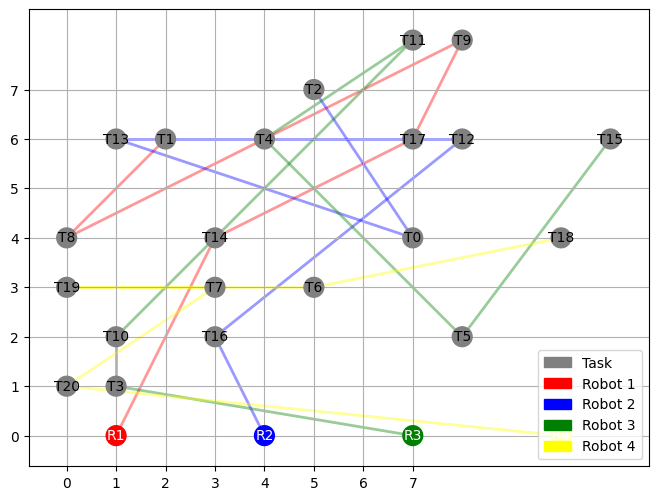

In [450]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define grid and positions
grid_size = (8, 8)  # Define the grid size
robot_colors = ['red', 'blue', 'green', 'yellow']

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]

# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Plot tasks and robots with labels
for idx, pos in enumerate(task_pos):
    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

# Draw paths from each robot to each task in sequence
#for robot_num, color in zip(set(robots), robot_colors):
    # Extract tasks for this robot
#    task_indices = [i for i, x in enumerate(robots) if x == robot_num]
#    print("ti:")
#    print(task_indices)
#    task_sequence = [tasks[i] for i in task_indices]
#    print("ts:")
#    print(task_sequence)

task_pos_pairs = list(zip(tasks, task_pos))

for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(task_sequence)

    # Initial position of the robot
    #start = robot_pos[robot_num - 1]
    start = robot_pos[robot_index]
    print("start")
    print(start)

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        #end = task_pos[task_num - 1]
        #end = task_pos[task_num]
        end = [pair[1] for pair in task_pos_pairs if pair[0] == task_num][0]
        print("end")
        print(end)
        # Calculate path
        path = a_star(start, end)
        # Draw the path
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=2, zorder=1, alpha=0.4)
        # Update the start position to the end of the last path
        start = end

# Create a legend for tasks and robots
task_legend = patches.Patch(color='gray', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca()#.invert_yaxis()  # Invert the y-axis to match your coordinate system
plt.show()



0 [14, 17, 9, 8, 1]
start
[1, 0]
end
[4, 6]
end
[5, 7]
end
[8, 8]
end
[7, 8]
end
[1, 2]
1 [16, 12, 13, 0, 2]
start
[4, 0]
end
[7, 4]
end
[1, 6]
end
[2, 6]
end
[1, 1]
end
[0, 1]
2 [3, 10, 11, 4, 5, 15]
start
[7, 0]
end
[3, 2]
end
[0, 3]
end
[0, 4]
end
[3, 4]
end
[3, 3]
end
[5, 3]
3 [20, 7, 19, 6, 18]
start
[10, 0]
end
[11, 6]
end
[8, 6]
end
[10, 4]
end
[7, 6]
end
[8, 2]


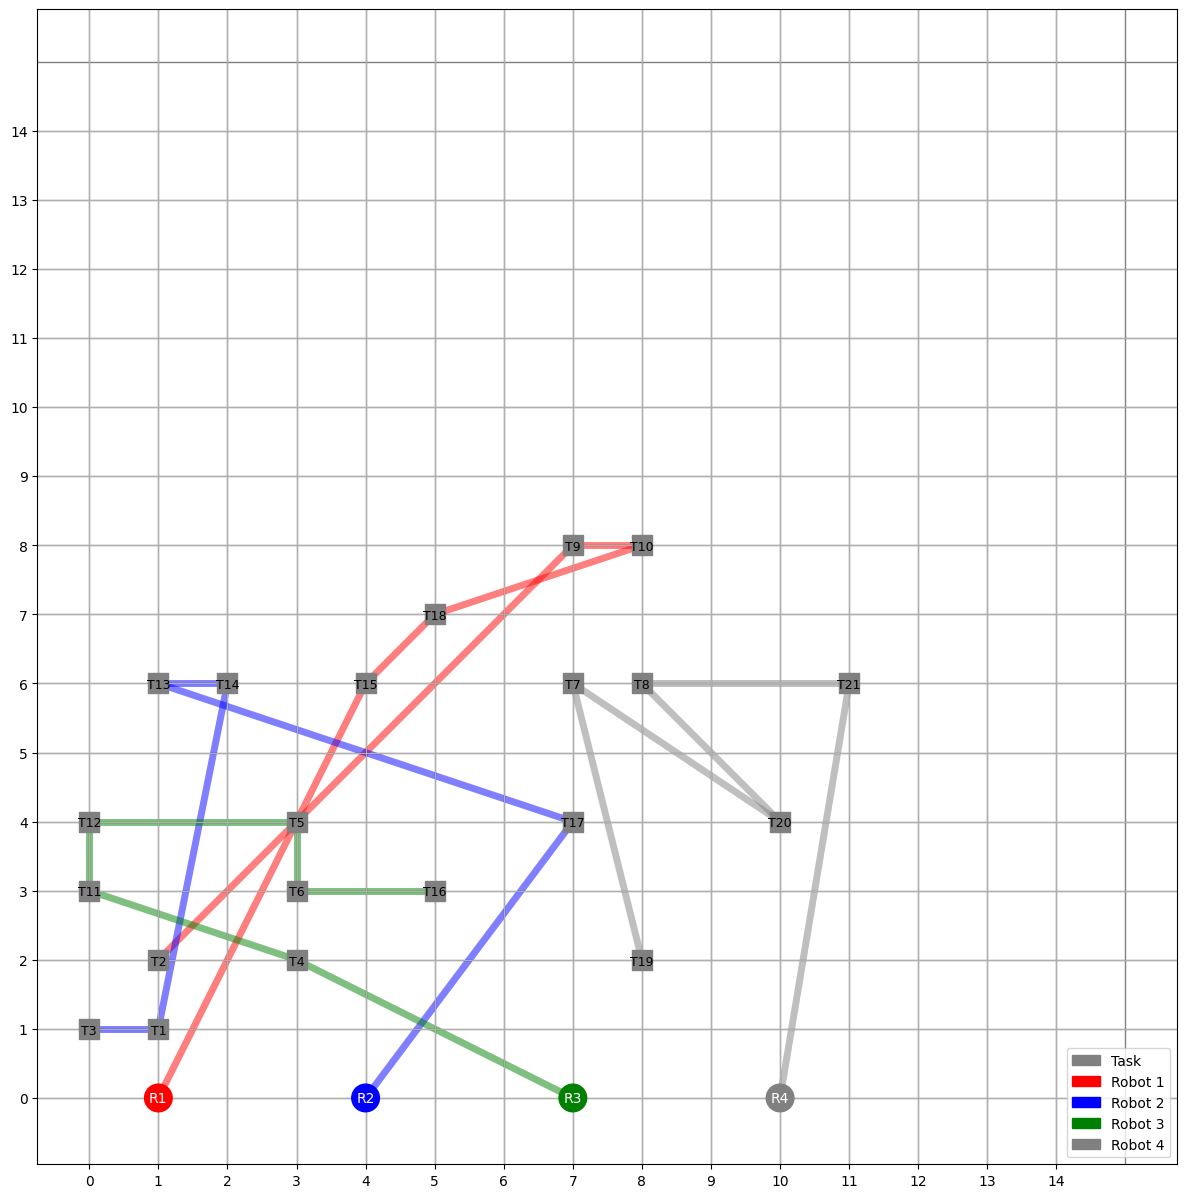

In [451]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#MAIN WORKING VIZ

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]



# Settings
grid_size = (15, 15)
robot_colors = ['red', 'blue', 'green', 'grey']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.5  # Transparency for paths

# Create figure and axes
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xlim(0, grid_size[0])
#ax.set_ylim(0, grid_size[1])

# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='grey', s=200, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)

#better plotting:
#for idx, pos in enumerate(task_pos):
#    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
#    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

"""
# Plotting setup
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Plot tasks and robots with labels
for idx, pos in enumerate(task_pos):
    ax.add_patch(patches.Circle(pos, 0.2, color='gray', zorder=2))
    ax.text(*pos, f'T{tasks[idx]}', horizontalalignment='center', verticalalignment='center', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

"""



# Draw paths from each robot to each task in sequence
#for robot_num, color in zip(set(robots), robot_colors):
    # Extract tasks for this robot
#    task_indices = [i for i, x in enumerate(robots) if x == robot_num]
#    print("ti:")
#    print(task_indices)
#    task_sequence = [tasks[i] for i in task_indices]
#    print("ts:")
#    print(task_sequence)

task_pos_pairs = list(zip(tasks, task_pos))

for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_index, task_sequence)

    # Initial position of the robot
    #start = robot_pos[robot_num - 1]
    start = robot_pos[robot_index]
    print("start")
    print(start)

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        #end = task_pos[task_num - 1]
        #end = task_pos[task_num]
        end = task_pos[task_num] #[pair[1] for pair in task_pos_pairs if pair[0] == task_num][0]
        print("end")
        print(end)
        # Calculate path
        path = a_star(start, end)
        # Draw the path
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=5, zorder=1, alpha=0.5)
        # Update the start position to the end of the last path
        start = end

# Create a legend for tasks and robots
task_legend = patches.Patch(color='gray', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.gca()#.invert_yaxis()  # Invert the y-axis to match your coordinate system
plt.show()



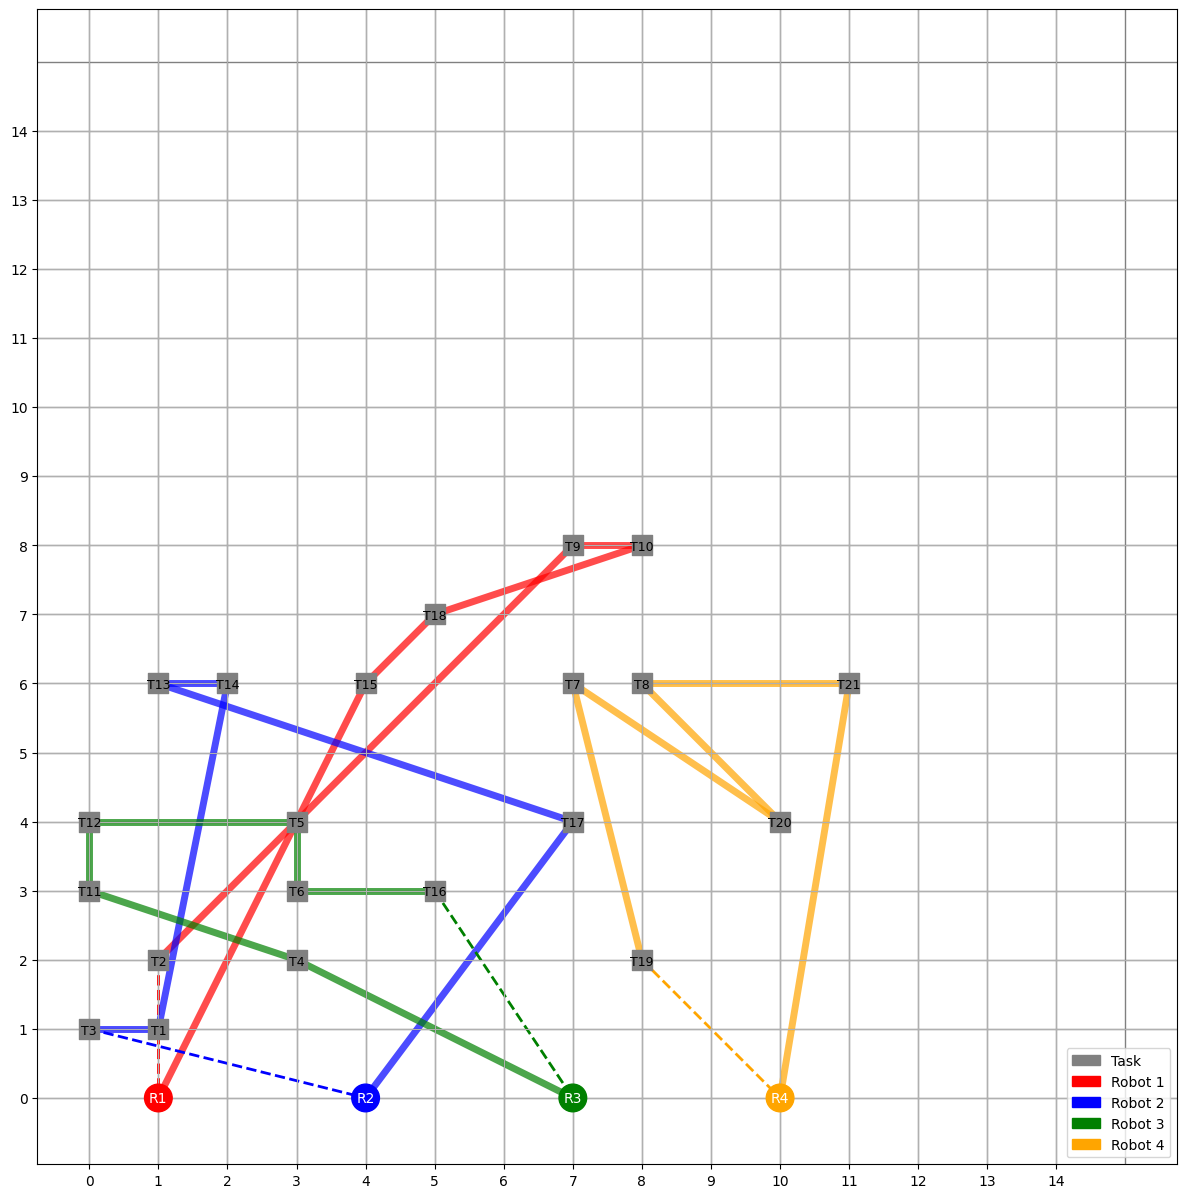

In [452]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Placeholder function for A*; replace with actual A* function
def a_star(start, goal):
    # This function should return a list of (x, y) tuples as the path from 'start' to 'goal'
    # Here it returns a direct line for illustration
    return [start, goal]

# Settings
grid_size = (15, 15)
robot_colors = ['red', 'blue', 'green', 'orange']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.7  # Transparency for paths

# Create figure and axes
fig, ax = plt.subplots(figsize=(grid_size[0], grid_size[1]))
ax.set_xticks(range(grid_size[0]))
ax.set_yticks(range(grid_size[1]))
plt.grid(True)

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='grey', s=200, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)

robot_patches = []  # Keep track of robot patches for the legend
for idx, (pos, color) in enumerate(zip(robot_pos, robot_colors)):
    robot_patch = patches.Circle(pos, 0.2, color=color, label=f'Robot {idx+1}', zorder=4)
    ax.add_patch(robot_patch)
    robot_patches.append(robot_patch)
    ax.text(*pos, f'R{idx+1}', color='white', ha='center', va='center', zorder=5)

# Draw paths from each robot to each task in sequence
for robot_index in set(robots):
    task_sequence = [pair[0] for pair in pairs if pair[1] == robot_index]

    # Initial position of the robot
    start = robot_pos[robot_index]

    # Draw paths for each task
    for task_num in task_sequence:
        # Destination task position
        end = task_pos[task_num]

        # Calculate path
        path = a_star(start, end)
        xs, ys = zip(*path)
        ax.plot(xs, ys, color=robot_colors[robot_index], linewidth=5, zorder=1, alpha=path_alpha)
        # Update the start position to the end of the last path
        start = end

    # Draw line between final task location and original robot position
    final_task_location = task_pos[task_sequence[-1]]
    ax.plot([final_task_location[0], robot_pos[robot_index][0]], [final_task_location[1], robot_pos[robot_index][1]],
            color=robot_colors[robot_index], linewidth=2, linestyle='--', zorder=1)

# Create a legend for tasks and robots
task_legend = patches.Patch(color='grey', label='Task')
plt.legend(handles=[task_legend] + robot_patches, loc='lower right')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [453]:
print(set(robots))
pairs = list(zip(tasks, robots))
print(pairs)

for task in tasks:
    print("a")
    print(task, task_pos[task])

robot_pos_pairs = list(zip(robots, robot_pos))

print(task_pos_pairs)
print(robot_pos_pairs)
assignments = []
for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_tasks)
    assignments.append(robot_tasks)
print(assignments)

n = 0
print(task_pos_pairs[n][1])

{0, 1, 2, 3}
[(3, 2), (10, 2), (20, 3), (16, 1), (14, 0), (7, 3), (17, 0), (12, 1), (11, 2), (9, 0), (19, 3), (8, 0), (13, 1), (1, 0), (4, 2), (6, 3), (0, 1), (2, 1), (5, 2), (18, 3), (15, 2)]
a
3 [3, 2]
a
10 [0, 3]
a
20 [11, 6]
a
16 [7, 4]
a
14 [4, 6]
a
7 [8, 6]
a
17 [5, 7]
a
12 [1, 6]
a
11 [0, 4]
a
9 [8, 8]
a
19 [10, 4]
a
8 [7, 8]
a
13 [2, 6]
a
1 [1, 2]
a
4 [3, 4]
a
6 [7, 6]
a
0 [1, 1]
a
2 [0, 1]
a
5 [3, 3]
a
18 [8, 2]
a
15 [5, 3]
[(3, [1, 1]), (10, [1, 2]), (20, [0, 1]), (16, [3, 2]), (14, [3, 4]), (7, [3, 3]), (17, [7, 6]), (12, [8, 6]), (11, [7, 8]), (9, [8, 8]), (19, [0, 3]), (8, [0, 4]), (13, [1, 6]), (1, [2, 6]), (4, [4, 6]), (6, [5, 3]), (0, [7, 4]), (2, [5, 7]), (5, [8, 2]), (18, [10, 4]), (15, [11, 6])]
[(2, [1, 0]), (2, [4, 0]), (3, [7, 0]), (1, [10, 0])]
[14, 17, 9, 8, 1]
[16, 12, 13, 0, 2]
[3, 10, 11, 4, 5, 15]
[20, 7, 19, 6, 18]
[[14, 17, 9, 8, 1], [16, 12, 13, 0, 2], [3, 10, 11, 4, 5, 15], [20, 7, 19, 6, 18]]
[1, 1]


0 [14, 17, 9, 8, 1]
1 [16, 12, 13, 0, 2]
2 [3, 10, 11, 4, 5, 15]
3 [20, 7, 19, 6, 18]


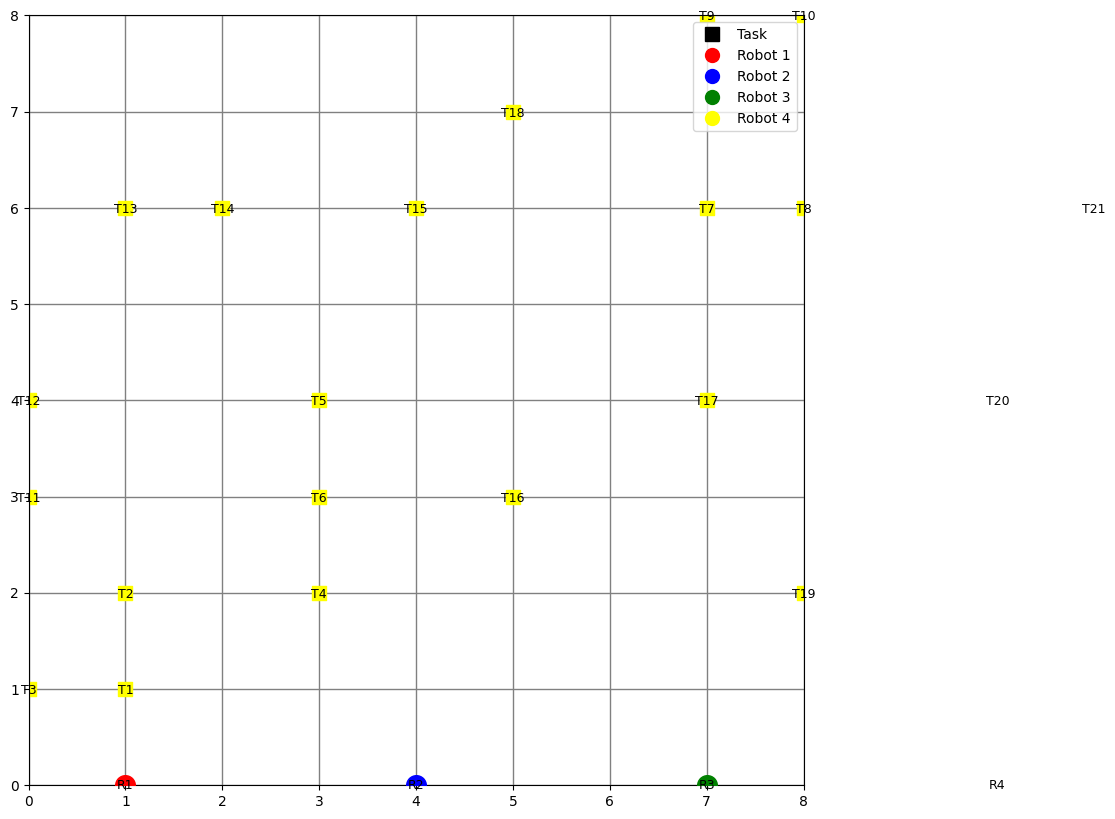

In [454]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np



# Settings
grid_size = (8, 8)
robot_colors = ['red', 'blue', 'green', 'yellow']
task_marker = 's'  # Square for tasks
robot_marker = 'o'  # Circle for robots
path_alpha = 0.4  # Transparency for paths

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, grid_size[0])
ax.set_ylim(0, grid_size[1])

# Draw grid
for x in range(grid_size[0] + 1):
    ax.axhline(x, lw=1, color='grey', zorder=0)
    ax.axvline(x, lw=1, color='grey', zorder=0)

# Plot tasks with labels
for i, pos in enumerate(task_pos):
    ax.scatter(pos[0], pos[1], c='yellow', s=100, marker=task_marker, label='Task' if i == 0 else "", zorder=2)
    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='center', va='center_baseline', zorder=3)
# Plot and label tasks
#for i, pos in enumerate(task_pos):
#    ax.plot(pos[0], pos[1], 'ko', zorder=5)  # Task positions as black dots
#    ax.text(pos[0], pos[1], f'T{i+1}', fontsize=9, ha='right')


# Plot and label robots initially
for i, pos in enumerate(robot_pos):
    ax.scatter(pos[0], pos[1], c=robot_colors[i], s=200, marker=robot_marker, label=f'Robot {i+1}', zorder=5)
    ax.text(pos[0], pos[1], f'R{i+1}', fontsize=9, ha='center', va='center', zorder=6)


for robot_index in set(robots):
    robot_tasks = [pair[0] for pair in pairs if pair[1] == robot_index]
    print(robot_index, robot_tasks)
    #start_pos = robot_pos[robot_index]
    #for task_index in robot_tasks:
    #    goal_pos = task_pos[tasks[task_index] - 1]
    #    path = a_star(start_pos, goal_pos, None)  # Assuming grid is not used in placeholder a_star
    #    xs, ys = zip(*path)
    #    ax.plot(xs, ys, c=robot_colors[robot_index], linewidth=2, alpha=path_alpha, zorder=4)
     #   start_pos = goal_pos  # Next start is the current goal

# Create custom legends
task_legend = mlines.Line2D([], [], color='black', marker=task_marker, linestyle='None', markersize=10, label='Task')
robot_legends = [mlines.Line2D([], [], color=color, marker=robot_marker, linestyle='None', markersize=10, label=f'Robot {i+1}') for i, color in enumerate(robot_colors)]
ax.legend(handles=[task_legend] + robot_legends)

plt.gca()#.invert_yaxis()  # Match grid coordinates if necessary
plt.show()